## **Predicting Disease Spread: Model Prophet**

### **Imports**

In [3]:
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

sys.path.append(os.path.abspath(".."))
from src.data_setup import load_data, split_cities
from src.prophet import (
    forecast_dengue_cases
)

from prophet import Prophet

import seaborn as sns

In [4]:
features_train, labels_train = load_data(train=True)
sj_features_train, iq_features_train = split_cities(features_train)
sj_labels_train, iq_labels_train = split_cities(labels_train)
features_test, labels_test = load_data(train=False)
sj_features_test, iq_features_test = split_cities(features_test)
iq_features_train_num = iq_features_train.drop(columns=['week_start_date'])
iq_features_test_num = iq_features_test.drop(columns=['week_start_date'])
sj_features_train_num = sj_features_train.drop(columns=['week_start_date'])
sj_features_test_num = sj_features_test.drop(columns=['week_start_date'])

### **Predictions (no tunning)**

In [ ]:
X_train_dict = {'sj': sj_features_train, 'iq': iq_features_train}
y_train_dict = {'sj': sj_labels_train, 'iq': iq_labels_train}
X_test_dict = {'sj': sj_features_test, 'iq': iq_features_test}

city_predictions = forecast_dengue_cases(X_train_dict, y_train_dict, X_test_dict)
all_predictions = []
for city, preds in city_predictions.items():
    city_test = X_test_dict[city]
    
    city_results = pd.DataFrame({
        'city': city,
        'year': city_test.index.get_level_values('year'),
        'weekofyear': city_test.index.get_level_values('weekofyear'),
        'total_cases': preds
    })
    
    all_predictions.append(city_results)

final_predictions = pd.concat(all_predictions)

final_predictions['total_cases'] = np.round(final_predictions['total_cases']).clip(0).astype(int)

print("Final predictions shape:", final_predictions.shape)
print(final_predictions.head())



Outputs:


SJ  
Best parameters found: {'changepoint_prior_scale': 0.01, 'daily_seasonality': False, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True, 'yearly_seasonality': True}
Best validation MAE: 27.16


IQ  
Best parameters found: {'changepoint_prior_scale': 0.05, 'daily_seasonality': False, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True, 'yearly_seasonality': True}
Best validation MAE: 6.41


In [18]:
final_predictions.to_csv('../data/predictions/prophet_htun.csv', index=False)

Predictions as mean of prophet and prophet with tunning

In [5]:
p = pd.read_csv('../data/predictions/prophet.csv')
ph = pd.read_csv('../data/predictions/prophet_htun.csv')

mean = (p['total_cases'] + ph['total_cases']) / 2

sumbission = pd.DataFrame({
    'city': p['city'],
    'year': p['year'],
    'weekofyear': p['weekofyear'],
    'total_cases': mean.clip(0).astype(int)
})

sumbission.to_csv('../data/predictions/prophet_mean.csv', index=False)

In [13]:
p[p["city"] == "sj"]

,city,year,weekofyear,total_cases
0,sj,2008,18,26
1,sj,2008,19,11
2,sj,2008,20,29
3,sj,2008,21,51
4,sj,2008,22,39
...,...,...,...,...
255,sj,2013,13,70
256,sj,2013,14,89
257,sj,2013,15,67
258,sj,2013,16,55


In [18]:
pm = pd.read_csv('../data/predictions/prophet_mean.csv')

<Axes: xlabel='weekofyear', ylabel='total_cases'>

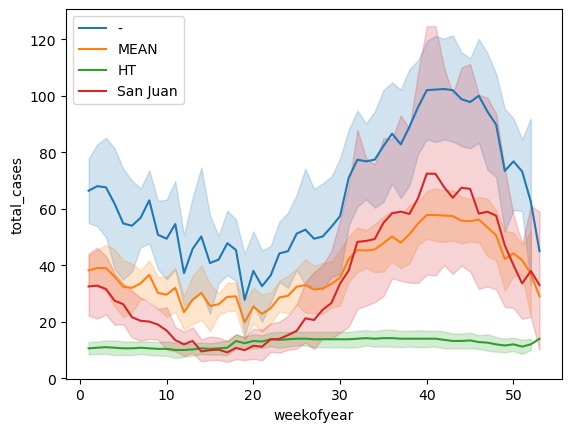

In [26]:
sns.lineplot(x="weekofyear", y="total_cases", data=p[p["city"] == "sj"], label="-")
sns.lineplot(x="weekofyear", y="total_cases", data=pm[pm["city"] == "sj"], label="MEAN")
sns.lineplot(x="weekofyear", y="total_cases", data=ph[ph["city"] == "sj"], label="HT")
sns.lineplot(x="weekofyear", y="total_cases", data=sj_labels_train, label="San Juan")


<Axes: xlabel='weekofyear', ylabel='total_cases'>

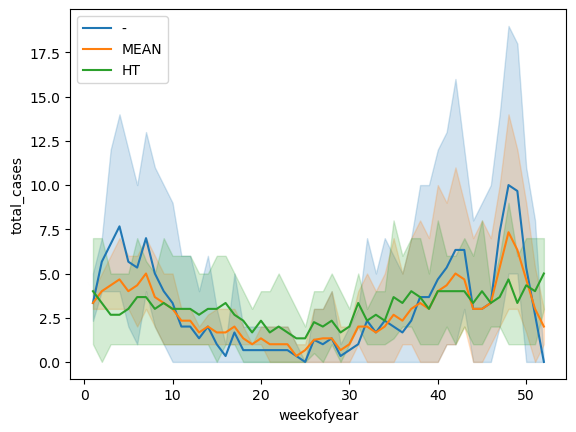

In [25]:
sns.lineplot(x="weekofyear", y="total_cases", data=p[p["city"] == "iq"], label="-")
sns.lineplot(x="weekofyear", y="total_cases", data=pm[pm["city"] == "iq"], label="MEAN")
sns.lineplot(x="weekofyear", y="total_cases", data=ph[ph["city"] == "iq"], label="HT")

<Axes: xlabel='weekofyear', ylabel='total_cases'>

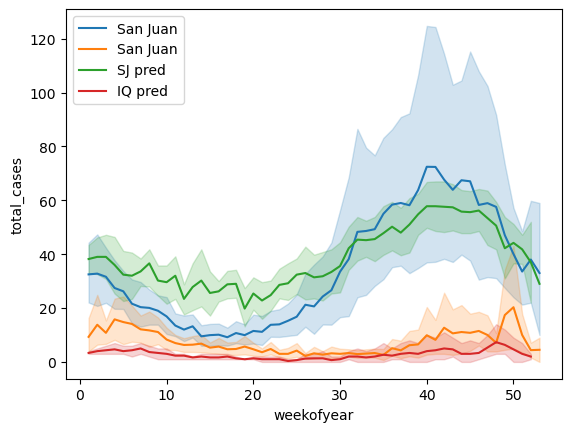

In [21]:
sns.lineplot(x="weekofyear", y="total_cases", data=sj_labels_train, label="San Juan")
sns.lineplot(x="weekofyear", y="total_cases", data=iq_labels_train, label="San Juan")
# sns.lineplot(x="weekofyear", y="total_cases", data=p[p["city"] == "sj"], label="SJ pred")
# sns.lineplot(x="weekofyear", y="total_cases", data=p[p["city"] == "iq"], label="IQ pred")
sns.lineplot(x="weekofyear", y="total_cases", data=pm[pm["city"] == "sj"], label="SJ pred")
sns.lineplot(x="weekofyear", y="total_cases", data=pm[pm["city"] == "iq"], label="IQ pred")


<Axes: xlabel='weekofyear', ylabel='total_cases'>

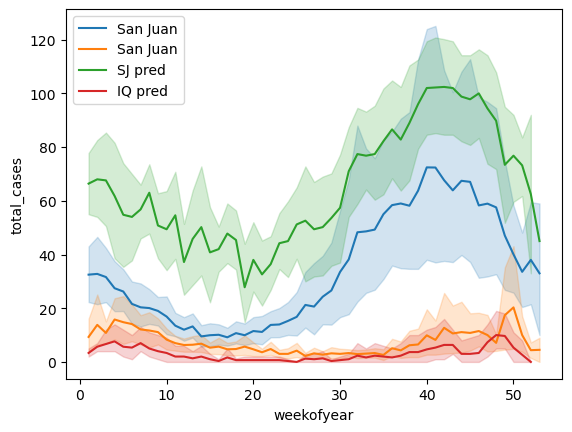

In [22]:
sns.lineplot(x="weekofyear", y="total_cases", data=sj_labels_train, label="San Juan")
sns.lineplot(x="weekofyear", y="total_cases", data=iq_labels_train, label="San Juan")
sns.lineplot(x="weekofyear", y="total_cases", data=p[p["city"] == "sj"], label="SJ pred")
sns.lineplot(x="weekofyear", y="total_cases", data=p[p["city"] == "iq"], label="IQ pred")

In [72]:
def predict_means(labels_train, features_test, city: str):
    means = labels_train.reset_index(level="weekofyear").groupby("weekofyear")["total_cases"].mean().round(0).astype(int)
    
    A = pd.DataFrame({"weekofyear": features_test.reset_index(level="weekofyear")["weekofyear"]}).reset_index()
    B = pd.DataFrame({"avg_ttl_cases": means}).reset_index()
    C = A.merge(B, on="weekofyear")
    C['city'] = city
    C = C[['city', 'year', 'weekofyear', 'avg_ttl_cases']]
    return C


In [73]:
estimated_sj = predict_means(sj_labels_train, sj_features_test, "sj")
estimated_iq = predict_means(iq_labels_train, iq_features_test, "iq")
estimated = pd.concat([estimated_sj, estimated_iq], axis=0).reset_index(drop=True).rename(columns={"avg_ttl_cases": "total_cases"})

In [75]:
estimated.to_csv('../data/predictions/estimated_as_mean.csv', index=False)